- 透過角修正

In [1]:
%load_ext Cython

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time 
import numpy as np

In [3]:
%%cython
#透過距離計算用プログラム
#x軸に沿ったスリットの平行移動を考える
def light_receiving_t_d(gradient , intercept, x_k, y_k, distance1, distance2, slit1, slit2, r_d, transmittance):
    
    #スリットの位置の定義
    #配列制作用
    const = r_d
    i = 0
    test_x = []
    test_y = []
    
    x1y1 = [[0 for i in range(2)] for i in range(const*2 +1)]
#     x1y1 = np.zeros((const*2 +1,2))
    x2y2 = [[0 for i in range(2)] for i in range(const*2 +1)]
#     x2y2 = np.zeros((const*2 +1,2))
    #とりあえず外径の　1.5倍外
    
#     step = [i for i in range(-const, const +1)]
    
    #ここおかしくね？？→0.1ばいしてるから10倍分多くループ回す必要ある。。。。
    #for d in [tmp*0.1 for tmp in range(-const, const+1)]:
    for d in range(-const, const+1):
        x1 = d
        y1 = -distance1
        x2 = d
        y2 = -distance2
        x1y1[i][0] = x1
        x1y1[i][1] = y1
        x2y2[i][0] = x2
        x2y2[i][1] = y2
        i += 1 
        test_x.append(x1)
        test_y.append(y1)


    count_light = [0] * (const *2 + 1)
    
    cnt_slit1 = 0
    cnt_slit2 = 0
    
    count_x = []
    count_y = []
    
    #透過距離
    distance_t = [i for i in range(const * 2 + 1)]
#     distance_t = np.arange(const * 2 + 1)
    #ここのとり方を変える
    #zip使うと遅くなる？→普通のforループに書き直しても良いかも
    for g, i, xk, yk, tm in zip(gradient, intercept, x_k, y_k, transmittance):
        if yk == 0:
            continue
        for j in range(-const, const +1): #-x,xで動かす
            #スリットと,光線の交点
            a = 0
            b = x1y1[j][1]
            x = (i - b)/(a - g)
            #スリット幅(斜めver)
            s_d = slit1/2
            #1つ目のスリットを超えられるかどうか
            ##この条件がおかしそう
            if x < x1y1[j][0] + s_d and x1y1[j][0] - s_d < x:
                #2つめの条件に変更
                #ここの計算間違っている説あり（要確認)
                b = x2y2[j][1]
                x = (i - b)/(a - g)
                s_d = slit2/2
                cnt_slit1 += 1
                #2つ目のスリットを超えられるかどうか
                if x < x2y2[j][0] + s_d and x2y2[j][0] - s_d < x:
                    cnt_slit2 += 1
                    #光の本数をカウント
                    count_light[j] += tm
                    count_x.append(x)
                    y = g*x + i
                    count_y.append(y)
                    
                    
    return count_light, distance_t, count_x, count_y, test_x, test_y
                    

In [4]:


#透過角 を求めるための回転装置をもしたシミュレーション
#90度だけで良さそう
#全ての直線データをぶちこむ
#外周座標は最後の透過角を求めるために必要。
# import time
#回転中心が違うぽい
def light_receiving_t_a(gradient ,intercept, x_k, y_k, distance1, distance2, slit1, slit2, center_x, center_y, transmittance):
    #print("値が入ってるか？",gradient[0],intercept[0],x_k[0],y_k[0],distance1,distance2)
#     t1 = time.time() 
    
    #まずslitの位置を定義 下準備
    #円管とスリットの距離の定義が必要
#     distance1 = 1
#     distance2 = 1
    i = 0
    test_x = []
    test_y = []
    
#     x1y1 = np.zeros((900,2))
#     x2y2 = np.zeros((900,2))
#     s_sita = np.zeros(1801)
    
    x1y1 = [[0 for i in range(2)] for i in range(900)]
    x2y2 = [[0 for i in range(2)] for i in range(900)]
    s_sita = [0 for i in range(1801)]
    
    for sita in [tmp*0.1 for tmp in range(1800, 2700)]:
        x1 = distance1*np.cos(np.deg2rad(sita)) + center_x
        y1 = distance1*np.sin(np.deg2rad(sita)) + center_y
        x2 = distance2*np.cos(np.deg2rad(sita)) + center_x
        y2 = distance2*np.sin(np.deg2rad(sita)) + center_y
        similar_sita = abs(np.arctan(np.tan(abs(x1)/abs(y1))))
        x1y1[i][0] = x1
        x1y1[i][1] = y1
        x2y2[i][0] = x2
        x2y2[i][1] = y2
        s_sita[i] = similar_sita
        i += 1
        test_x.append(x1)
        test_y.append(y1)
        
    # 経過時間を表示
#     t2 = time.time()
#     elapsed_time_1 = t2-t1
#     print(f"経過時間：{elapsed_time_1}","秒")
#     print("---------------下準備終了！------------------")
    
#     t3 = time.time() 
    #スリット幅を入力
    #need to change
#     slit1 = 1
#     slit2 = 1
    #ある角度における光線の本数カウント用
    count_light = [0] * 900
    count_x = [0] * 900
    count_y = [0] * 900
#     t_angle = [0] * 900
    t_angle = [0] * 900
    
    cnt_slit1 = 0
    cnt_slit2 = 0
    count_x = []
    count_y = []
    
    for g, i, xk, yk, tm in zip(gradient, intercept, x_k, y_k, transmittance):
        if yk == 0:
            continue
        for j in range(900): #90度分の回転を表す
            #スリットの傾きと,光線の交点
            a = -np.tan(s_sita[j])
            b = x1y1[j][1] - a*x1y1[j][0]
            x = (i - b)/(a - g)
            #スリット幅(斜めver)
            s_d = slit1*np.cos(abs(s_sita[j]))/2
            #1つ目のスリットを超えられるかどうか
            if x < x1y1[j][0] + s_d and x1y1[j][0] - s_d < x:
                #2つめの条件に変更
                b = x2y2[j][1] - a*x2y2[j][0]
                x = (i - b)/(a - g)
                s_d = slit2*np.cos(abs(s_sita[j]))/2
                cnt_slit1 += 1
                #2つ目のスリットを超えられるかどうか
                if x < x2y2[j][0] + s_d and x2y2[j][0] - s_d < x:
                    cnt_slit2 += 1
                    #光の本数をカウント
                    count_light[j] += tm
#                     #透過角算出用のx,yもおいておきたい→平均orとりあえずmin,maxの2つをキープしておいて考える。
#                     #怪しい、場合によってはmaxminが大幅に離れてる？→ここはどのへんに値が偏っているのかを見てもいいかも一旦保留
                    
#                     ##ここで透過角を計算する
#                     count_x[j] += xk
#                     count_y[j] += yk
                    #ここで透過角を入れていけば良いんじゃないだろうか？
#                     x_slit2 = x2y2[j][0]
#                     y_slit2 = x2y2[j][1]
                    count_x.append(x)
                    y = g*x + i
                    count_y.append(y)
                    a = y - yk
                    b = xk - x
                    c = 1
                    d = 0
                    t_angle[j] = np.rad2deg(np.arctan(np.tan(abs(a*d - b*c)/abs(a*c + b*d))))
    
    # 経過時間を表示
#     t4 = time.time()
#     elapsed_time_2 = t4-t3
#     print(f"経過時間：{elapsed_time_2}","秒")
#     print("---------------光線の処理完了！------------------")
#     print("スリット1枚目を超えられた本数",cnt_slit1)
#     print("スリット2枚目を超えられた本数",cnt_slit2)
    #print("光線の本数は？",sum(count_light))
    
#     t5 = time.time()
    #jごとの透過角を求める必要がある(横軸)
#     for j in range(900):
#         #ある角度jのときのスリットを透過する外周の点の平均
#         if count_light[j] == 0:
#             continue
#         x_g = count_x[j]/count_light[j]
#         y_g = count_y[j]/count_light[j]
#         x_slit2 = x2y2[j][0]
#         y_slit2 = x2y2[j][1]
#         a = y_slit2 - y_g
#         b = x_g - x_slit2
#         c = 1
#         d = 0
#         t_angle[j] = np.rad2deg(np.arctan(np.tan(abs(a*d - b*c)/abs(a*c + b*d))))
        
    # 経過時間を表示
#     t6 = time.time()
#     elapsed_time_3 = t6-t5
#     print(f"経過時間：{elapsed_time_3}","秒")
#     print("---------------透過角算出！------------------")
    
#     print("総実行時間:",(elapsed_time_1+elapsed_time_2+elapsed_time_3)/60,"分")
    
    
    return count_light, t_angle, count_x, count_y, test_x, test_y

データ読み込み数: 76286
経過時間： 0.0018289724985758463 分
---------------下準備終了！------------------
透過角算出!
経過時間： 4.554767235120138 分
---------------------------------
経過時間： 18.204956682523093 分
---------------------------------


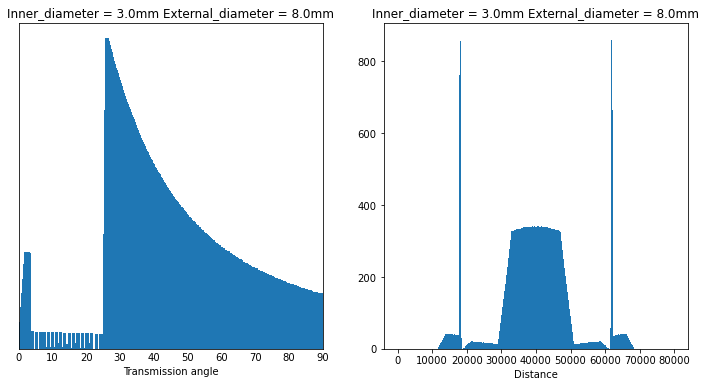

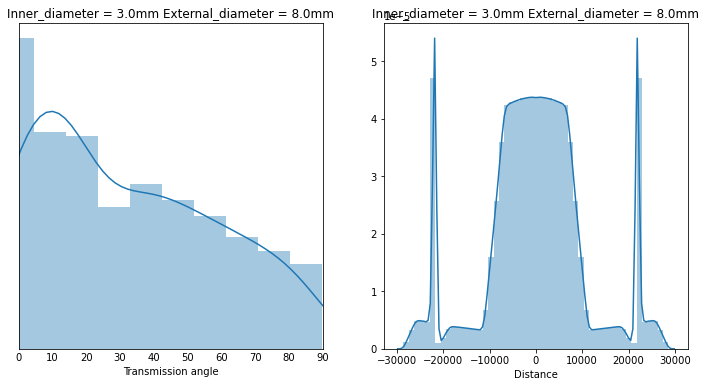

In [15]:
#### テスト用
# %%cython
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time 
import numpy as np
import seaborn as sns
#need to change

r = 40000
r_i = 15000
r_i = round(r_i)
#1mm → 10000  0.2mm → 2000 0.05mm → 500
#円管とスリットの距離

h1 = 5000
h2 = 10000
d1 = r + h1
d2 = d1 + h2
#スリット幅
s1 = 2000
s2 = 500
t1 = time.time() 
#複数のCSVファイルを順次読み込んでグラフを表示していく
df = pd.read_csv('./data_csv3/dataset_r_i_{0}_r_{1}.csv'.format(r_i, r))
new_x_a_list = df['x'] 
new_y_a_list = df['y']
gradient_list = df['gradient']
intercept_list = df['intercept']
center_x_list = df['change_x']
center_y_list = df['change_y']
transmittance_slist = df['transmittance_s']
transmittance_plist = df['transmittance_p']
transmittance_list = [s+p for s,p in zip(transmittance_slist ,transmittance_plist)]
print("データ読み込み数:",len(new_x_a_list))

t2 = time.time()
elapsed_time_1 = t2-t1
print("経過時間：",elapsed_time_1/60,"分")
print("---------------下準備終了！------------------")
t3 = time.time() 
light_num_a, toka_angle,light_x1,light_y1,debug_x1,debug_y1 = light_receiving_t_a(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2, center_x_list[0], center_y_list[0], transmittance_list)
print("透過角算出!")
t4 = time.time()
elapsed_time_2 = t4-t3
print("経過時間：",elapsed_time_2/60,"分")
print("---------------------------------")
d1 = r + h1
d2 = d1 + h2
t5 = time.time() 
light_num_d, distance,light_x,light_y,debug_x2,debug_y2 = light_receiving_t_d(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2, r, transmittance_list)
t6 = time.time()
elapsed_time_3 = t6-t5
print("経過時間：",elapsed_time_3/60,"分")
print("---------------------------------")
fig = plt.figure(figsize=(12,6))
#         fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_xlim([0,90])
ax1.bar(toka_angle, light_num_a, width=1.0)
ax2.bar(distance, light_num_d, width=1.0)
ax1.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax2.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax1.set_xlabel('Transmission angle')
ax2.set_xlabel('Distance')
ax1.set_yticklabels([])
#         ax2.set_yticklabels([])
ax1.tick_params(length=0)
#         ax2.tick_params(length=0)
#plt.show()
# fig.savefig('./figure_data/cnt_figure_d1_{0}_d2_{1}.png'.format(d1, d2))

fig2 = plt.figure(figsize=(12,6))
#         fig.subplots_adjust(wspace=0.5)
ax3 = fig2.add_subplot(1, 2, 1)
ax4 = fig2.add_subplot(1, 2, 2)
sns.distplot(toka_angle, ax = ax3)
sns.distplot(light_x, ax = ax4)
ax3.set_xlim([0,90])
ax3.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax4.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax3.set_xlabel('Transmission angle')
ax4.set_xlabel('Distance')
ax3.set_yticklabels([])
#         ax2.set_yticklabels([])
ax3.tick_params(length=0)
#         ax2.tick_params(length=0)
#plt.show()
# fig2.savefig('./figure_hist/figure_d1_{0}_d2_{1}.png'.format(d1, d2))

#計算用
inner_diameter_distance = []
inner_diameter_angle = []
expected_innner_diameter_1 = []
expected_innner_diameter_2 = []
num_1 = len(light_num_d)
inner_diameter_distance = [0]*num_1
expected_innner_diameter_1 = [0]*num_1
num_2 = len(light_num_a)
inner_diameter_angle = [0]*num_2
expected_innner_diameter_2 = [0]*num_2

tmp = 0
tmp2 = 0
for i in range(len(light_num_a)):   
    if tmp < light_num_a[i]:
        tmp = light_num_a[i]
        tmp2 = toka_angle[i]

# print("光線数",tmp,"透過角",tmp2)

tmp3 = 0
tmp4 = 0

for i in range(int(len(light_num_d)/2)):   
    if tmp3 < light_num_d[i]:
        tmp3 = light_num_d[i]
        tmp4 = distance[i]

max_value = max(light_num_d)
max_index = light_num_d.index(max_value)
tmp3 = distance[max_index]
# print(tmp)

# print("光線数",tmp,"透過距離",(distance[-1]-tmp3*2)/10000,"mm")
# print("-----------------------------------------------------")
#透過距離からの計算
a_toka = (distance[-1]-tmp3*2)/10000
D = 2*r/10000
n = 1.49/1.000292

d_ans_1 = (-pow(a_toka,3)-np.sqrt(pow(a_toka,6)+pow(a_toka,2)*pow(D,2)*(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))))/(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))
d_ans_2 = (-pow(a_toka,3)+np.sqrt(pow(a_toka,6)+pow(a_toka,2)*pow(D,2)*(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))))/(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))
# print("透過距離からの計算")
# print("内径1:",d_ans_1,"内径2:",d_ans_2)
# print("-----------------------------------------------------")

if r_i*2 - d_ans_1*10000 < r_i*2 - d_ans_2*10000:
    d_ans = d_ans_1
else:
    d_ans = d_ans_2
    
# print(d_ans)
#透過角からの計算
sita_ans = np.deg2rad(tmp2)
d_ans_3 = np.sqrt((pow(D,2)*pow(np.sin(sita_ans/2),2))/(pow(n,2)-2*n*np.cos(sita_ans/2)+1))
# print("透過角からの計算")
# print(d_ans_3)
# print("-----------------------------------------------------")
#期待する内径
# print("期待する内径")
# print(r_i*2/10000,"mm")

inner_diameter_distance[0] = d_ans
inner_diameter_angle[0] = d_ans_3
expected_innner_diameter_1[0] = r_i*2/10000
expected_innner_diameter_2[0] = r_i*2/10000

df = pd.DataFrame({
    'through_strength_distance':light_num_d,
    'distance':distance,
    'inner_diameter_distance':inner_diameter_distance,
    'expected_innner_diameter':expected_innner_diameter_1
})

df.to_csv('./data_strength/distance_d1_{0}_d2_{1}_r_i_{2}_r_{3}.csv'.format(d1, d2, r_i, r), index=False)

df2 = pd.DataFrame({
    'through_strength_angle':light_num_a,
    'through_angle':toka_angle,
    'inner_diameter_angle':inner_diameter_angle,
    'expected_innner_diameter':expected_innner_diameter_2
})

df2.to_csv('./data_strength/angle_d1_{0}_d2_{1}_r_i_{2}_r_{3}.csv'.format(d1, d2, r_i, r), index=False)




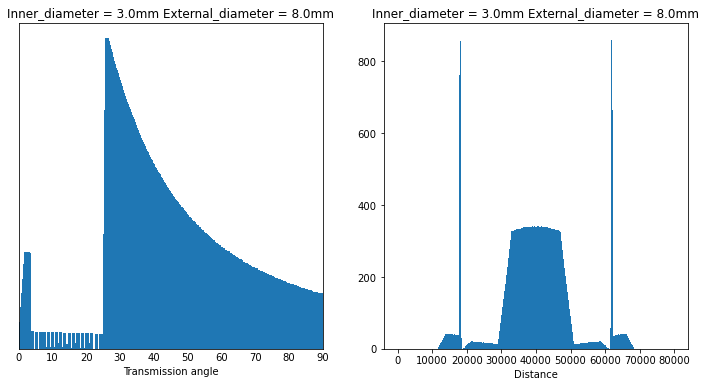

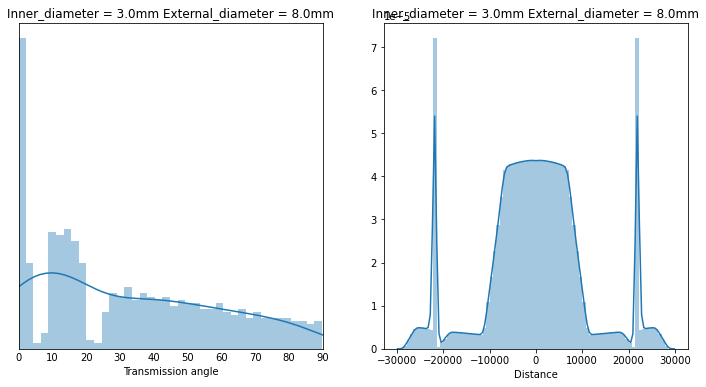

In [17]:
fig = plt.figure(figsize=(12,6))
#         fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_xlim([0,90])
ax1.bar(toka_angle, light_num_a, width=1.0)
ax2.bar(distance, light_num_d, width=1.0)
ax1.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax2.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax1.set_xlabel('Transmission angle')
ax2.set_xlabel('Distance')
ax1.set_yticklabels([])
#         ax2.set_yticklabels([])
ax1.tick_params(length=0)
#         ax2.tick_params(length=0)
#plt.show()
# fig.savefig('./figure_data/cnt_figure_d1_{0}_d2_{1}.png'.format(d1, d2))

fig2 = plt.figure(figsize=(12,6))
#         fig.subplots_adjust(wspace=0.5)
ax3 = fig2.add_subplot(1, 2, 1)
ax4 = fig2.add_subplot(1, 2, 2)
sns.distplot(toka_angle, ax = ax3,bins = 80)
sns.distplot(light_x, ax = ax4,bins =int(2*r/1000))
ax3.set_xlim([0,90])
ax3.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax4.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
ax3.set_xlabel('Transmission angle')
ax4.set_xlabel('Distance')
ax3.set_yticklabels([])
#         ax2.set_yticklabels([])
ax3.tick_params(length=0)
#         ax2.tick_params(length=0)
#plt.show()
# fig2.savefig('./figure_hist/figure_d1_{0}_d2_{1}.png'.format(d1, d2))


In [5]:
#計算用
inner_diameter_distance = []
inner_diameter_angle = []
expected_innner_diameter_1 = []
expected_innner_diameter_2 = []
num_1 = len(light_num_d)
inner_diameter_distance = [0]*num_1
expected_innner_diameter_1 = [0]*num_1
num_2 = len(light_num_a)
inner_diameter_angle = [0]*num_2
expected_innner_diameter_2 = [0]*num_2

tmp = 0
tmp2 = 0
for i in range(len(light_num_a)):   
    if tmp < light_num_a[i]:
        tmp = light_num_a[i]
        tmp2 = toka_angle[i]

# print("光線数",tmp,"透過角",tmp2)

tmp3 = 0
tmp4 = 0

for i in range(int(len(light_num_d)/2)):   
    if tmp3 < light_num_d[i]:
        tmp3 = light_num_d[i]
        tmp4 = distance[i]

max_value = max(light_num_d)
max_index = light_num_d.index(max_value)
tmp3 = distance[max_index]
# print(tmp)

# print("光線数",tmp,"透過距離",(distance[-1]-tmp3*2)/10000,"mm")
# print("-----------------------------------------------------")
#透過距離からの計算
a_toka = (distance[-1]-tmp3*2)/10000
D = 2*r/10000
n = 1.49/1.000292

d_ans_1 = (-pow(a_toka,3)-np.sqrt(pow(a_toka,6)+pow(a_toka,2)*pow(D,2)*(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))))/(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))
d_ans_2 = (-pow(a_toka,3)+np.sqrt(pow(a_toka,6)+pow(a_toka,2)*pow(D,2)*(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))))/(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))
# print("透過距離からの計算")
print("内径1:",d_ans_1,"内径2:",d_ans_2)
# print("-----------------------------------------------------")

if r_i*2 - d_ans_1*10000 < r_i*2 - d_ans_2*10000:
    d_ans = d_ans_1
else:
    d_ans = d_ans_2
    
print(d_ans)
#透過角からの計算
sita_ans = np.deg2rad(tmp2)
d_ans_3 = np.sqrt((pow(D,2)*pow(np.sin(sita_ans/2),2))/(pow(n,2)-2*n*np.cos(sita_ans/2)+1))
# print("透過角からの計算")
print(d_ans_3)
# print("-----------------------------------------------------")
#期待する内径
# print("期待する内径")
# print(r_i*2/10000,"mm")

inner_diameter_distance[0] = d_ans
inner_diameter_angle[0] = d_ans_3
expected_innner_diameter_1[0] = r_i*2/10000
expected_innner_diameter_2[0] = r_i*2/10000

# df = pd.DataFrame({
#     'through_strength_distance':light_num_d,
#     'distance':distance,
#     'inner_diameter_distance':inner_diameter_distance,
#     'expected_innner_diameter':expected_innner_diameter_1
# })

# df.to_csv('./data_strength/distance_d1_{0}_d2_{1}_r_i_{2}_r_{3}.csv'.format(d1, d2, r_i, r), index=False)

# df2 = pd.DataFrame({
#     'through_strength_angle':light_num_a,
#     'through_angle':toka_angle,
#     'inner_diameter_angle':inner_diameter_angle,
#     'expected_innner_diameter':expected_innner_diameter_2
# })

# df2.to_csv('./data_strength/angle_d1_{0}_d2_{1}_r_i_{2}_r_{3}.csv'.format(d1, d2, r_i, r), index=False)





内径1: -4.9868491336178025 内径2: 2.9743985615844757
2.9743985615844757
3.2242212905361125


In [12]:
20000 - 2* light_num_d.index(max(light_num_d))

8450

rの変位域-40000<=r<=40000
取得したxの数 9579274


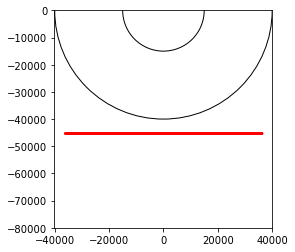

In [11]:
#座標確認

import matplotlib.pyplot as plt
import matplotlib.patches as patches

g = plt.subplot()
#外径
draw_circle_r = plt.Circle((0, 0), r, fill=False)
#内径
draw_circle_i = plt.Circle((0, 0), r_i, fill=False)
g.add_artist(draw_circle_r)
g.add_artist(draw_circle_i)
g.plot(light_x, light_y, marker="o", color = "red", linestyle = " ",markersize=1)

g.set_aspect('equal')
g.set_xlim([-r-100,r+100])
g.set_ylim([-r*2,0])

print("rの変位域{0}<=r<={1}".format(-r,r))
print("取得したxの数",len(light_x))



rの変位域-40000<=r<=40000
取得したxの数 72188


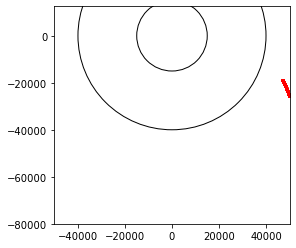

In [12]:
#座標確認

import matplotlib.pyplot as plt
import matplotlib.patches as patches

g = plt.subplot()
#外径
draw_circle_r = plt.Circle((0, 0), r, fill=False)
#内径
draw_circle_i = plt.Circle((0, 0), r_i, fill=False)
g.add_artist(draw_circle_r)
g.add_artist(draw_circle_i)
g.plot(light_x1, light_y1, marker="o", color = "red", linestyle = " ",markersize=1)

g.set_aspect('equal')
g.set_xlim([-r-10000,r+10000])
g.set_ylim([-r*2,12500])

print("rの変位域{0}<=r<={1}".format(-r,r))
print("取得したxの数",len(light_x1))

rの変位域-40000<=r<=40000
取得したxの数 72188


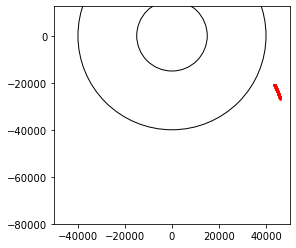

In [13]:
#座標確認

import matplotlib.pyplot as plt
import matplotlib.patches as patches

g = plt.subplot()
#外径
draw_circle_r = plt.Circle((0, 0), r, fill=False)
#内径
draw_circle_i = plt.Circle((0, 0), r_i, fill=False)
g.add_artist(draw_circle_r)
g.add_artist(draw_circle_i)
g.plot(debug_x1, debug_y1, marker="o", color = "red", linestyle = " ",markersize=1)

g.set_aspect('equal')
g.set_xlim([-r-10000,r+10000])
g.set_ylim([-r*2,12500])

print("rの変位域{0}<=r<={1}".format(-r,r))
print("取得したxの数",len(light_x1))

rの変位域-40000<=r<=40000
取得したxの数 244186


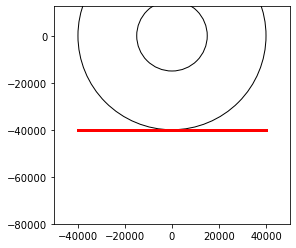

In [13]:
#座標確認

import matplotlib.pyplot as plt
import matplotlib.patches as patches

g = plt.subplot()
#外径
draw_circle_r = plt.Circle((0, 0), r, fill=False)
#内径
draw_circle_i = plt.Circle((0, 0), r_i, fill=False)
g.add_artist(draw_circle_r)
g.add_artist(draw_circle_i)
g.plot(debug_x2, debug_y2, marker="o", color = "red", linestyle = " ",markersize=1)

g.set_aspect('equal')
g.set_xlim([-r-10000,r+10000])
g.set_ylim([-r*2,12500])

print("rの変位域{0}<=r<={1}".format(-r,r))
print("取得したxの数",len(light_x1))

# 内径計算
$n$:屈折率 $d$:内径 $D$:外径 $a$:透過距離

$$
d = \frac{-a^3\pm\sqrt{a^6+a^2D^2(n^2(D^2-a^2)-a^2})}{n^2(D^2-a^2)-a^2}
$$

In [6]:
tmp = 0
tmp2 = 0
for i in range(len(light_num_a)):   
    if tmp < light_num_a[i]:
        tmp = light_num_a[i]
        tmp2 = toka_angle[i]

print("光線数",tmp,"透過角",tmp2)

tmp3 = 0
tmp4 = 0

for i in range(int(len(light_num_d)/2)):   
    if tmp3 < light_num_d[i]:
        tmp3 = light_num_d[i]
        tmp4 = distance[i]

max_value = max(light_num_d)
max_index = light_num_d.index(max_value)
tmp3 = distance[max_index]
print(tmp)

print("光線数",tmp,"透過距離",(distance[-1]-tmp3*2)/10000,"mm")
print("-----------------------------------------------------")
#透過距離からの計算
a_toka = (distance[-1]-tmp3*2)/10000
# print(a_toka)
D = 2*r/10000
n = 1.49/1.000292
# test = pow(a_toka,6)+pow(a_toka,2)*pow(D,2)*(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))
# print(test)

# A = ((n**2)*(D**2 - a_toka**2) - a_toka**2)
# B = 2*(a_toka**3)
# C = (-(a_toka**2)*(D**2))
# test = B**2 - 4*A*C

# print(test)
d_ans_1 = (-pow(a_toka,3)-np.sqrt(pow(a_toka,6)+pow(a_toka,2)*pow(D,2)*(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))))/(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))
d_ans_2 = (-pow(a_toka,3)+np.sqrt(pow(a_toka,6)+pow(a_toka,2)*pow(D,2)*(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))))/(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))
print("透過距離からの計算")
print("内径1:",d_ans_1,"内径2:",d_ans_2)
print("-----------------------------------------------------")

#透過角からの計算
sita_ans = np.deg2rad(tmp2)
d_ans_3 = np.sqrt((pow(D,2)*pow(np.sin(sita_ans/2),2))/(pow(n,2)-2*n*np.cos(sita_ans/2)+1))
print("透過角からの計算")
print(d_ans_3)
print("-----------------------------------------------------")
#期待する内径
print("期待する内径")
print(r_i*2/10000,"mm")

光線数 979.5123162756593 透過角 26.252741143523867
979.5123162756593
光線数 979.5123162756593 透過距離 4.3416 mm
-----------------------------------------------------
透過距離からの計算
内径1: -4.9868491336178025 内径2: 2.9743985615844757
-----------------------------------------------------
透過角からの計算
3.2242212905361125
-----------------------------------------------------
期待する内径
3.0 mm


In [ ]:
#テスト用
# %%cython
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time 
import numpy as np
import seaborn as sns
#need to change

r = 40000
r_i = 15000
r_i = round(r_i)
df = pd.read_csv('./data_csv3/dataset_r_i_{0}_r_{1}.csv'.format(r_i, r))
new_x_a_list = df['x'] 
new_y_a_list = df['y']
gradient_list = df['gradient']
intercept_list = df['intercept']
center_x_list = df['change_x']
center_y_list = df['change_y']
transmittance_slist = df['transmittance_s']
transmittance_plist = df['transmittance_p']
transmittance_list = [s+p for s,p in zip(transmittance_slist ,transmittance_plist)]
#1mm → 10000  0.2mm → 2000 0.05mm → 500
#円管とスリットの距離
for temp1 in range(3000, 10000, 1000):
    for temp2 in range(1000, 10000, 1000):
        h1 = temp1
        h2 = temp2
        d1 = r + h1
        d2 = d1 + h2
        #スリット幅
        s1 = 2000
        s2 = 500
#         t1 = time.time() 
        #複数のCSVファイルを順次読み込んでグラフを表示していく
#         df = pd.read_csv('./data_csv3/dataset_r_i_{0}_r_{1}.csv'.format(r_i, r))
#         new_x_a_list = df['x'] 
#         new_y_a_list = df['y']
#         gradient_list = df['gradient']
#         intercept_list = df['intercept']
#         center_x_list = df['change_x']
#         center_y_list = df['change_y']
#         transmittance_slist = df['transmittance_s']
#         transmittance_plist = df['transmittance_p']
#         transmittance_list = [s+p for s,p in zip(transmittance_slist ,transmittance_plist)]
#         print("データ読み込み数:",len(new_x_a_list))

#         t2 = time.time()
#         elapsed_time_1 = t2-t1
#         print("経過時間：",elapsed_time_1/60,"分")
#         print("---------------下準備終了！------------------")
#         t3 = time.time() 
        light_num_a, toka_angle,light_x1,light_y1,debug_x1,debug_y1 = light_receiving_t_a(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2, center_x_list[0], center_y_list[0], transmittance_list)
#         print("透過角算出!")
#         t4 = time.time()
#         elapsed_time_2 = t4-t3
#         print("経過時間：",elapsed_time_2/60,"分")
#         print("---------------------------------")
#         d1 = r + h1
#         d2 = d1 + h2
#         t5 = time.time() 
        light_num_d, distance,light_x,light_y,debug_x2,debug_y2 = light_receiving_t_d(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2, r, transmittance_list)
#         t6 = time.time()
#         elapsed_time_3 = t6-t5
#         print("経過時間：",elapsed_time_3/60,"分")
#         print("---------------------------------")
        fig = plt.figure(figsize=(12,6))
        #         fig.subplots_adjust(wspace=0.5)
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        ax1.set_xlim([0,90])
        ax1.bar(toka_angle, light_num_a, width=1.0)
        ax2.bar(distance, light_num_d, width=1.0)
        ax1.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax2.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax1.set_xlabel('Transmission angle')
        ax2.set_xlabel('Distance')
        ax1.set_yticklabels([])
        #         ax2.set_yticklabels([])
        ax1.tick_params(length=0)
        #         ax2.tick_params(length=0)
        #plt.show()
        fig.savefig('./figure_data_5/cnt_figure_d1_{0}_d2_{1}.png'.format(d1, d2))
        plt.close(fig)

        fig2 = plt.figure(figsize=(12,6))
        #         fig.subplots_adjust(wspace=0.5)
        ax3 = fig2.add_subplot(1, 2, 1)
        ax4 = fig2.add_subplot(1, 2, 2)
        sns.distplot(toka_angle, ax = ax3)
        sns.distplot(light_x, ax = ax4)
        ax3.set_xlim([0,90])
        ax3.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax4.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax3.set_xlabel('Transmission angle')
        ax4.set_xlabel('Distance')
        ax3.set_yticklabels([])
        #         ax2.set_yticklabels([])
        ax3.tick_params(length=0)
        #         ax2.tick_params(length=0)
        #plt.show()
        fig2.savefig('./figure_hist_5/figure_d1_{0}_d2_{1}.png'.format(d1, d2))
        plt.close(fig2)

        #計算用
        inner_diameter_distance = []
        inner_diameter_angle = []
        expected_innner_diameter_1 = []
        expected_innner_diameter_2 = []
        num_1 = len(light_num_d)
        inner_diameter_distance = [0]*num_1
        expected_innner_diameter_1 = [0]*num_1
        num_2 = len(light_num_a)
        inner_diameter_angle = [0]*num_2
        expected_innner_diameter_2 = [0]*num_2

        tmp = 0
        tmp2 = 0
        for i in range(len(light_num_a)):   
            if tmp < light_num_a[i]:
                tmp = light_num_a[i]
                tmp2 = toka_angle[i]

        # print("光線数",tmp,"透過角",tmp2)

        tmp3 = 0
        tmp4 = 0

        for i in range(int(len(light_num_d)/2)):   
            if tmp3 < light_num_d[i]:
                tmp3 = light_num_d[i]
                tmp4 = distance[i]

        max_value = max(light_num_d)
        max_index = light_num_d.index(max_value)
        tmp3 = distance[max_index]
        # print(tmp)

        # print("光線数",tmp,"透過距離",(distance[-1]-tmp3*2)/10000,"mm")
        # print("-----------------------------------------------------")
        #透過距離からの計算
        a_toka = (distance[-1]-tmp3*2)/10000
        D = 2*r/10000
        n = 1.49/1.000292

        d_ans_1 = (-pow(a_toka,3)-np.sqrt(pow(a_toka,6)+pow(a_toka,2)*pow(D,2)*(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))))/(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))
        d_ans_2 = (-pow(a_toka,3)+np.sqrt(pow(a_toka,6)+pow(a_toka,2)*pow(D,2)*(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))))/(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))
        # print("透過距離からの計算")
        # print("内径1:",d_ans_1,"内径2:",d_ans_2)
        # print("-----------------------------------------------------")

        if r_i*2 - d_ans_1*10000 < r_i*2 - d_ans_2*10000:
            d_ans = d_ans_1
        else:
            d_ans = d_ans_2

        # print(d_ans)
        #透過角からの計算
        sita_ans = np.deg2rad(tmp2)
        d_ans_3 = np.sqrt((pow(D,2)*pow(np.sin(sita_ans/2),2))/(pow(n,2)-2*n*np.cos(sita_ans/2)+1))
        # print("透過角からの計算")
        # print(d_ans_3)
        # print("-----------------------------------------------------")
        #期待する内径
        # print("期待する内径")
        # print(r_i*2/10000,"mm")

        inner_diameter_distance[0] = d_ans
        inner_diameter_angle[0] = d_ans_3
        expected_innner_diameter_1[0] = r_i*2/10000
        expected_innner_diameter_2[0] = r_i*2/10000

        df = pd.DataFrame({
            'through_strength_distance':light_num_d,
            'distance':distance,
            'inner_diameter_distance':inner_diameter_distance,
            'expected_innner_diameter':expected_innner_diameter_1
        })

        df.to_csv('./data_strength3/distance_d1_{0}_d2_{1}_r_i_{2}_r_{3}.csv'.format(d1, d2, r_i, r), index=False)

        df2 = pd.DataFrame({
            'through_strength_angle':light_num_a,
            'through_angle':toka_angle,
            'inner_diameter_angle':inner_diameter_angle,
            'expected_innner_diameter':expected_innner_diameter_2
        })

        df2.to_csv('./data_strength3/angle_d1_{0}_d2_{1}_r_i_{2}kee_r_{3}.csv'.format(d1, d2, r_i, r), index=False)



In [7]:
def print_varsize():
    import types
    print("{}{: >15}{}{: >10}{}".format('|','Variable Name','|','  Size','|'))
    print(" -------------------------- ")
    for k, v in globals().items():
        if hasattr(v, 'size') and not k.startswith('_') and not isinstance(v,types.ModuleType):
            print("{}{: >15}{}{: >10}{}".format('|',k,'|',str(v.size),'|'))
        elif hasattr(v, '__len__') and not k.startswith('_') and not isinstance(v,types.ModuleType):
            print("{}{: >15}{}{: >10}{}".format('|',k,'|',str(len(v)),'|'))

In [ ]:
# %%cython
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import time 
import numpy as np
import seaborn as sns
#need to change

cnt = 0

for step in range(39500, 40500, 500):
    for step_i in range(3000, 15500, 500):
#         if step == 39000 and step_i < 4000:
#             continue
            
#     for threshold in [tmp*0.1 for tmp in range(1, 10)]:
        r = step
        r_i = step_i
        r_i = round(r_i)
    #1mm → 10000  0.2mm → 2000 0.05mm → 500
    #円管とスリットの距離

        h1 = 5000
        h2 = 10000
        d1 = r + h1
        d2 = d1 + h2
        #スリット幅
        s1 = 2000
        s2 = 500
    #         t1 = time.time() 
        #複数のCSVファイルを順次読み込んでグラフを表示していく
        df = pd.read_csv('./data_csv_previous_study2/dataset_r_i_{0}_r_{1}.csv'.format(r_i, r))
        new_x_a_list = df['x'] 
        new_y_a_list = df['y']
        gradient_list = df['gradient']
        intercept_list = df['intercept']
        center_x_list = df['change_x']
        center_y_list = df['change_y']
        transmittance_slist = df['transmittance_s']
        transmittance_plist = df['transmittance_p']
        transmittance_list = [s+p for s,p in zip(transmittance_slist ,transmittance_plist)]
        cnt += 1
        if center_x_list[0] == 0 and center_y_list[0] == 0:
            print('回転中心を定義できないため「dataset_r_i_{0}_r_{1}.csv」を飛ばしました'.format(r_i, r))
            print('--------------------------------------------------------------')
            continue
        print('「dataset_r_i_{0}_r_{1}.csv」を解析中'.format(r_i, r))

    #         t2 = time.time()
    #         elapsed_time_1 = t2-t1
    #         print("経過時間：",elapsed_time_1/60,"分")
    #         print("---------------下準備終了！------------------")
    #         t3 = time.time() 
        light_num_a, toka_angle,light_x1,light_y1,debug_x1,debug_y1 = light_receiving_t_a(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2, center_x_list[0], center_y_list[0], transmittance_list)
    #         print("透過角算出!")
    #         t4 = time.time()
    #         elapsed_time_2 = t4-t3
    #         print("経過時間：",elapsed_time_2/60,"分")
    #         print("---------------------------------")
        d1 = r + h1
        d2 = d1 + h2
    #         t5 = time.time() 
        light_num_d, distance,light_x,light_y,debug_x2,debug_y2 = light_receiving_t_d(gradient_list ,intercept_list, new_x_a_list, new_y_a_list, d1, d2,s1 ,s2, r, transmittance_list)
    #         t6 = time.time()
    #         elapsed_time_3 = t6-t5
    #         print("経過時間：",elapsed_time_3/60,"分")
    #         print("---------------------------------")
        fig = plt.figure(figsize=(12,6))
        #         fig.subplots_adjust(wspace=0.5)
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        ax1.set_xlim([0,90])
        ax1.bar(toka_angle, light_num_a, width=1.0)
        ax2.bar(distance, light_num_d, width=1.0)
        ax1.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax2.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
        ax1.set_xlabel('Transmission angle')
        ax2.set_xlabel('Distance')
        ax1.set_yticklabels([])
        #         ax2.set_yticklabels([])
        ax1.tick_params(length=0)
        #         ax2.tick_params(length=0)
        #plt.show()
        fig.savefig('./figure_previous_study/cnt_figure_d1_{0}_d2_{1}_r_i_{2}_r_{3}.png'.format(d1, d2, r_i, r))
        plt.close(fig)

    #         fig2 = plt.figure(figsize=(12,6))
    #         #         fig.subplots_adjust(wspace=0.5)
    #         ax3 = fig2.add_subplot(1, 2, 1)
    #         ax4 = fig2.add_subplot(1, 2, 2)
    #         sns.distplot(toka_angle, ax = ax3,bins = 90)
    #         sns.distplot(light_x, ax = ax4,bins =int(2*r/1000))
    #         ax3.set_xlim([0,90])
    #         ax3.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
    #         ax4.set_title('Inner_diameter = {0}mm External_diameter = {1}mm'.format(r_i*2/10000, r*2/10000))
    #         ax3.set_xlabel('Transmission angle')
    #         ax4.set_xlabel('Distance')
    #         ax3.set_yticklabels([])
    #         #         ax2.set_yticklabels([])
    #         ax3.tick_params(length=0)
    #         #         ax2.tick_params(length=0)
    #         #plt.show()
    #         fig2.savefig('./figure_hist/figure_d1_{0}_d2_{1}.png'.format(d1, d2))
    #         plt.close(fig2)

        #計算用
        inner_diameter_distance = []
        inner_diameter_angle = []
        expected_innner_diameter_1 = []
        expected_innner_diameter_2 = []
        num_1 = len(light_num_d)
        inner_diameter_distance = [0]*num_1
        expected_innner_diameter_1 = [0]*num_1
        num_2 = len(light_num_a)
        inner_diameter_angle = [0]*num_2
        expected_innner_diameter_2 = [0]*num_2

        tmp = 0
        tmp2 = 0
        for i in range(len(light_num_a)):   
            if tmp < light_num_a[i]:
                tmp = light_num_a[i]
                tmp2 = toka_angle[i]

        # print("光線数",tmp,"透過角",tmp2)

        tmp3 = 0
        tmp4 = 0

        for i in range(int(len(light_num_d)/2)):   
            if tmp3 < light_num_d[i]:
                tmp3 = light_num_d[i]
                tmp4 = distance[i]

        max_value = max(light_num_d)
        max_index = light_num_d.index(max_value)
        tmp3 = distance[max_index]
        # print(tmp)

        # print("光線数",tmp,"透過距離",(distance[-1]-tmp3*2)/10000,"mm")
        # print("-----------------------------------------------------")
        #透過距離からの計算
        a_toka = (distance[-1]-tmp3*2)/10000
        D = 2*r/10000
        n = 1.49/1.000292

        d_ans_1 = (-pow(a_toka,3)-np.sqrt(pow(a_toka,6)+pow(a_toka,2)*pow(D,2)*(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))))/(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))
        d_ans_2 = (-pow(a_toka,3)+np.sqrt(pow(a_toka,6)+pow(a_toka,2)*pow(D,2)*(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))))/(pow(n,2)*(pow(D,2)-pow(a_toka,2))-pow(a_toka,2))
        # print("透過距離からの計算")
        # print("内径1:",d_ans_1,"内径2:",d_ans_2)
        # print("-----------------------------------------------------")

        if r_i*2 - d_ans_1*10000 < r_i*2 - d_ans_2*10000:
            d_ans = d_ans_1
        else:
            d_ans = d_ans_2

        # print(d_ans)
        #透過角からの計算
        sita_ans = np.deg2rad(tmp2)
        d_ans_3 = np.sqrt((pow(D,2)*pow(np.sin(sita_ans/2),2))/(pow(n,2)-2*n*np.cos(sita_ans/2)+1))
        # print("透過角からの計算")
        # print(d_ans_3)
        # print("-----------------------------------------------------")
        #期待する内径
        # print("期待する内径")
        # print(r_i*2/10000,"mm")

        inner_diameter_distance[0] = d_ans
        inner_diameter_angle[0] = d_ans_3
        expected_innner_diameter_1[0] = r_i*2/10000
        expected_innner_diameter_2[0] = r_i*2/10000

        df = pd.DataFrame({
            'through_strength_distance':light_num_d,
            'distance':distance,
            'inner_diameter_distance':inner_diameter_distance,
            'expected_innner_diameter':expected_innner_diameter_1
        })

        df.to_csv('./data_strength_previous_study2/distance_d1_{0}_d2_{1}_r_i_{2}_r_{3}.csv'.format(d1, d2, r_i, r), index=False)

        df2 = pd.DataFrame({
            'through_strength_angle':light_num_a,
            'through_angle':toka_angle,
            'inner_diameter_angle':inner_diameter_angle,
            'expected_innner_diameter':expected_innner_diameter_2
        })

        df2.to_csv('./data_strength_previous_study2/angle_d1_{0}_d2_{1}_r_i_{2}_r_{3}.csv'.format(d1, d2, r_i, r), index=False)

        print_varsize()






「dataset_r_i_3000_r_39500.csv」を解析中
|  Variable Name|      Size|
 -------------------------- 
|             In|         9|
|            Out|         0|
|             df|    316004|
|   new_x_a_list|     78756|
|   new_y_a_list|     78756|
|  gradient_list|     78756|
| intercept_list|     78756|
|  center_x_list|     78756|
|  center_y_list|     78756|
|transmittance_slist|     78756|
|transmittance_plist|     78756|
|transmittance_list|     78756|
|    light_num_a|       900|
|     toka_angle|       900|
|       light_x1|    159902|
|       light_y1|    159902|
|       debug_x1|       900|
|       debug_y1|       900|
|    light_num_d|     79001|
|       distance|     79001|
|        light_x|   1986482|
|        light_y|   1986482|
|       debug_x2|     79001|
|       debug_y2|     79001|
|inner_diameter_distance|     79001|
|inner_diameter_angle|       900|
|expected_innner_diameter_1|     79001|
|expected_innner_diameter_2|       900|
|           tmp2|         1|
|        d_ans_1|   

|  Variable Name|      Size|
 -------------------------- 
|             In|         9|
|            Out|         0|
|             df|    316004|
|   new_x_a_list|     78072|
|   new_y_a_list|     78072|
|  gradient_list|     78072|
| intercept_list|     78072|
|  center_x_list|     78072|
|  center_y_list|     78072|
|transmittance_slist|     78072|
|transmittance_plist|     78072|
|transmittance_list|     78072|
|    light_num_a|       900|
|     toka_angle|       900|
|       light_x1|    149462|
|       light_y1|    149462|
|       debug_x1|       900|
|       debug_y1|       900|
|    light_num_d|     79001|
|       distance|     79001|
|        light_x|   1449842|
|        light_y|   1449842|
|       debug_x2|     79001|
|       debug_y2|     79001|
|inner_diameter_distance|     79001|
|inner_diameter_angle|       900|
|expected_innner_diameter_1|     79001|
|expected_innner_diameter_2|       900|
|           tmp2|         1|
|        d_ans_1|         1|
|        d_ans_2|         